In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb

In [2]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(self.annotations['dx'].unique())}
        self.inverse_mapping = {v: k for k, v in self.label_mapping.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations.iloc[idx]['image_id']
        label_str = self.annotations.iloc[idx]['dx']
        label = self.label_mapping[label_str]

        for dir_path in self.img_dirs:
            img_path = os.path.join(dir_path, img_id + ".jpg")
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break
        else:
            raise FileNotFoundError(f"Image {img_id}.jpg not found.")

        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random


sns.set(style="whitegrid")
csv_path = r"D:\download\archive DS50\HAM10000_metadata.csv"
df = pd.read_csv(csv_path)

print("data overview：")
print(df.head())
print("\nLabel Type：", df['dx'].unique())
print("\nNumber of labels：\n", df['dx'].value_counts())



data overview：
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Label Type： ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Number of labels：
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [4]:
df.shape

(10015, 7)

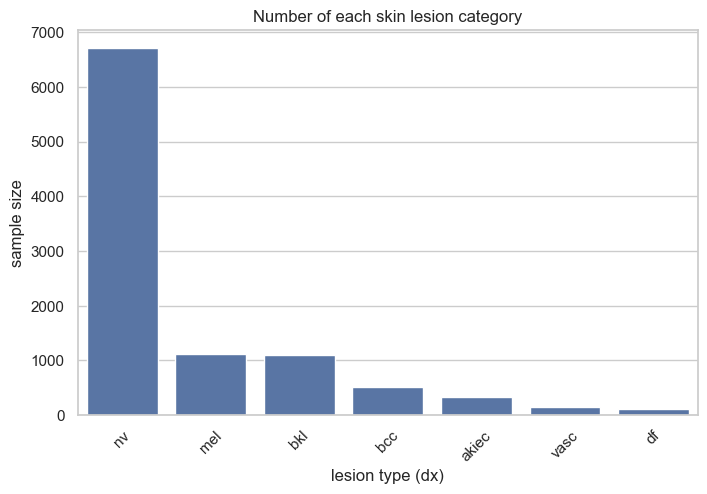

In [5]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.countplot(x='dx', data=df, order=df['dx'].value_counts().index)
plt.title("Number of each skin lesion category")
plt.xlabel("lesion type (dx)")
plt.ylabel("sample size")
plt.xticks(rotation=45)
plt.show()

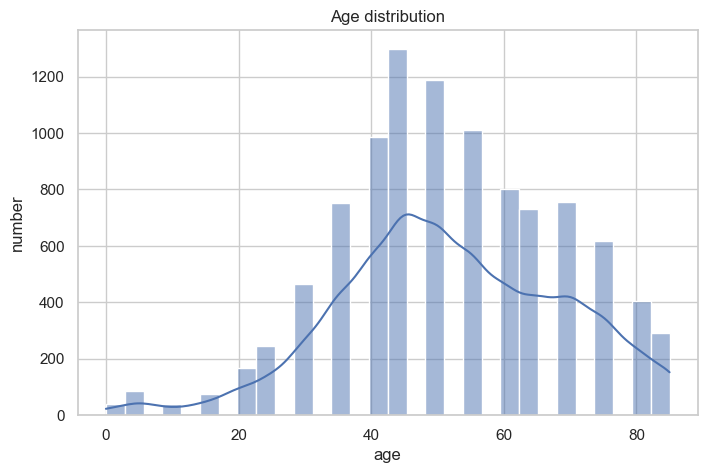

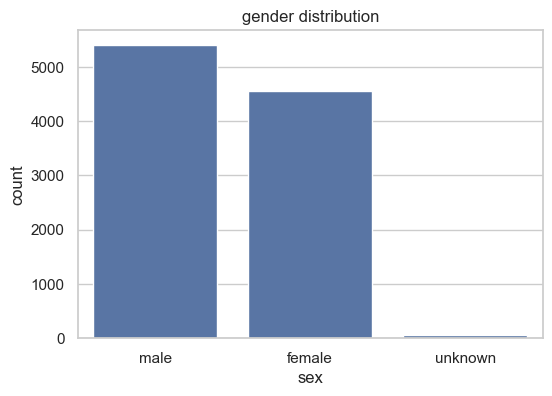

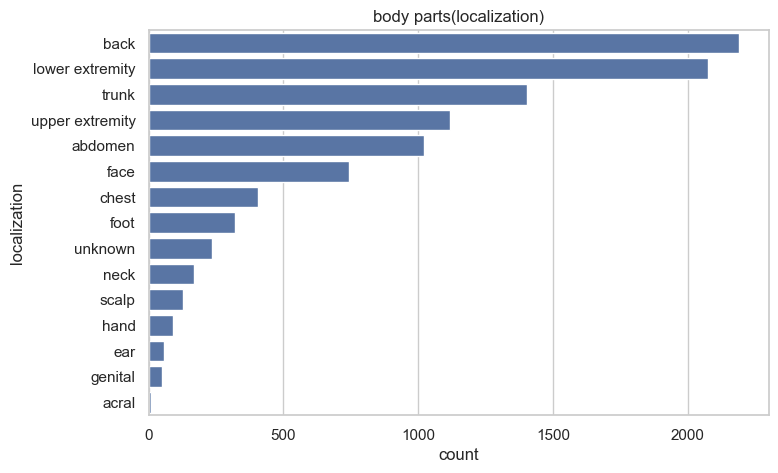

In [6]:

plt.figure(figsize=(8,5))
sns.histplot(df['age'].dropna(), bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel("age")
plt.ylabel("number")
plt.show()


plt.figure(figsize=(6,4))
sns.countplot(x='sex', data=df)
plt.title("gender distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.countplot(y='localization', data=df, order=df['localization'].value_counts().index)
plt.title("body parts(localization)")
plt.show()

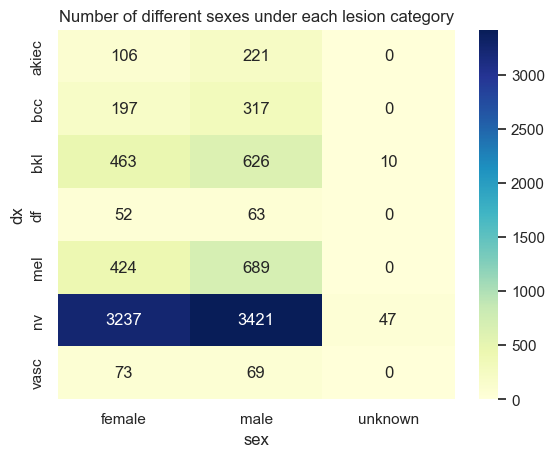

In [7]:
cross = pd.crosstab(df['dx'], df['sex'])
sns.heatmap(cross, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Number of different sexes under each lesion category")
plt.show()

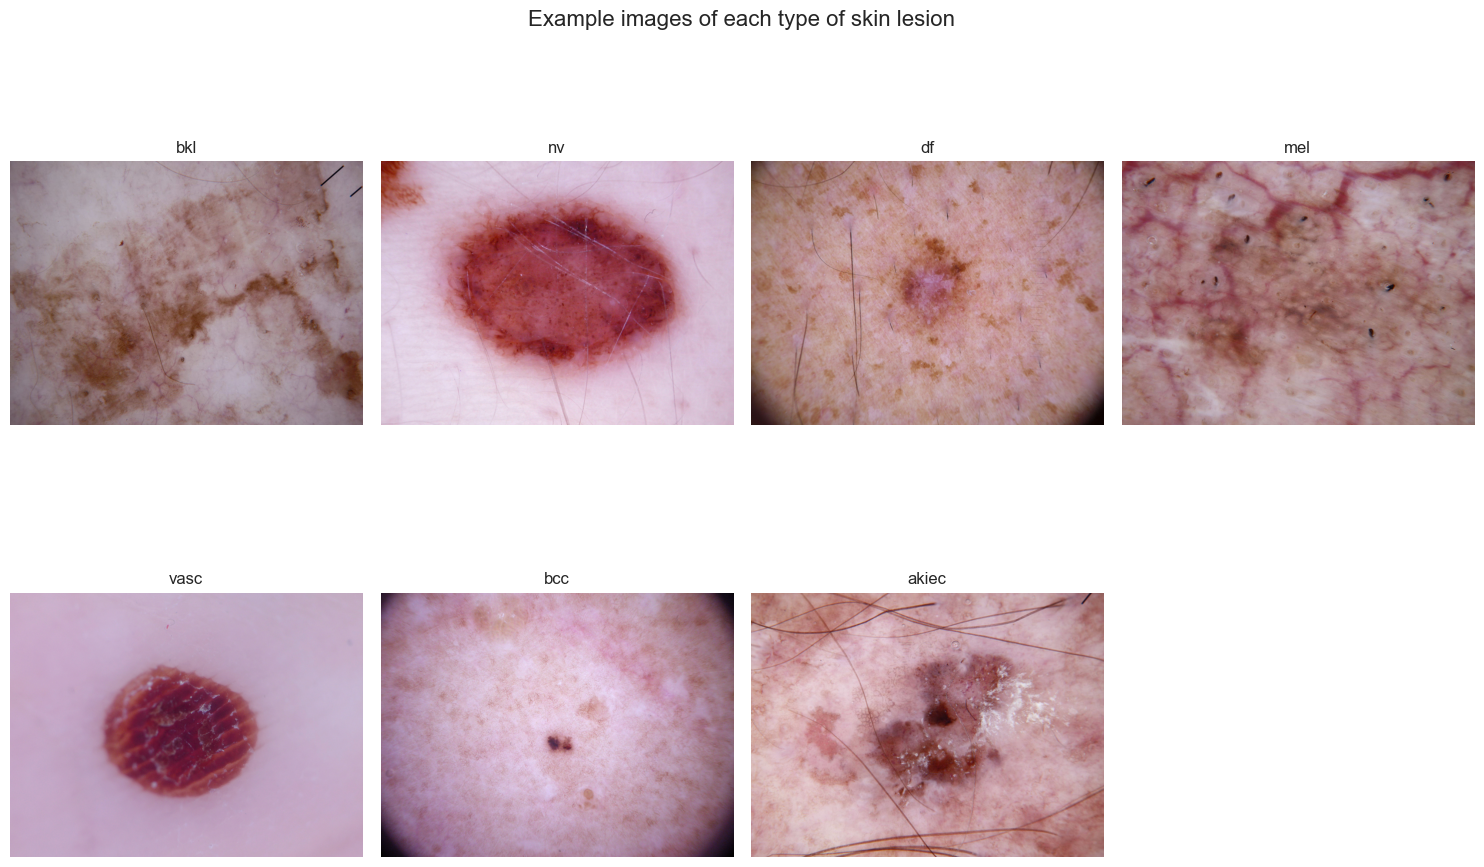

In [8]:
img_dirs = [
    r"D:\download\archive DS50\HAM10000_images_part_1",
    r"D:\download\archive DS50\HAM10000_images_part_2"
]

def find_image_path(image_id):
    for d in img_dirs:
        path = os.path.join(d, image_id + ".jpg")
        if os.path.exists(path):
            return path
    return None


unique_labels = df['dx'].unique()
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels):
    img_row = df[df['dx'] == label].sample(1).iloc[0]
    img_path = find_image_path(img_row['image_id'])
    if img_path:
        img = Image.open(img_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

plt.suptitle("Example images of each type of skin lesion", fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
wandb.login(key="8f54f75ecc69df541a0c38072576bc4aa5b158f4")

wandb.init(project="DS50", name="resnet50_baseline")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\123\_netrc


Using device: cuda


In [38]:
# import zipfile
# from pathlib import Path

# # 1) Point to your ZIP in Drive
# zip_path = Path("/content/drive/MyDrive/HAM10000.zip")
# assert zip_path.exists(), f"ZIP not found at {zip_path}"

# # 2) Peek at its contents to get the exact internal path
# with zipfile.ZipFile(zip_path, 'r') as z:
#     print("Archive contents:")
#     for name in z.namelist():
#         print("  ", name)

# # 3) Extract just the metadata CSV to your Drive root (or wherever you like)
# #    Copy the exact name printed above if it’s inside a folder, e.g. "HAM10000/HAM10000_metadata.csv"
# internal_csv = "HAM10000_metadata.csv"
# with zipfile.ZipFile(zip_path, 'r') as z:
#     z.extract(internal_csv, path="/content/drive/MyDrive/")

# print(f"\nExtracted {internal_csv} to /content/drive/MyDrive/")


Output streaming troncato alle ultime 5000 righe.
   ham10000_images_part_2/ISIC_0029327.jpg
   ham10000_images_part_2/ISIC_0029328.jpg
   ham10000_images_part_2/ISIC_0029329.jpg
   ham10000_images_part_2/ISIC_0029330.jpg
   ham10000_images_part_2/ISIC_0029331.jpg
   ham10000_images_part_2/ISIC_0029332.jpg
   ham10000_images_part_2/ISIC_0029333.jpg
   ham10000_images_part_2/ISIC_0029334.jpg
   ham10000_images_part_2/ISIC_0029335.jpg
   ham10000_images_part_2/ISIC_0029336.jpg
   ham10000_images_part_2/ISIC_0029337.jpg
   ham10000_images_part_2/ISIC_0029338.jpg
   ham10000_images_part_2/ISIC_0029339.jpg
   ham10000_images_part_2/ISIC_0029340.jpg
   ham10000_images_part_2/ISIC_0029341.jpg
   ham10000_images_part_2/ISIC_0029342.jpg
   ham10000_images_part_2/ISIC_0029343.jpg
   ham10000_images_part_2/ISIC_0029344.jpg
   ham10000_images_part_2/ISIC_0029345.jpg
   ham10000_images_part_2/ISIC_0029346.jpg
   ham10000_images_part_2/ISIC_0029347.jpg
   ham10000_images_part_2/ISIC_0029348.jpg
   h

In [39]:
# import os, glob

# # 1. Show top‐level of your Drive
# print("Drive root folders:", os.listdir("/content/drive/MyDrive"))

# # 2. Search recursively for the metadata CSV
# matches = glob.glob("/content/drive/MyDrive/**/HAM10000_metadata.csv", recursive=True)
# print("Found metadata CSV at these locations:")
# for p in matches:
#     print("  ", p)

Drive root folders: ['Classroom', 'Colab Notebooks', 'HAM10000.zip', 'archive.zip', 'HAM10000_metadata.csv']
Found metadata CSV at these locations:
   /content/drive/MyDrive/HAM10000_metadata.csv


In [10]:
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# ✅ Local paths to the extracted image folders and CSV file (update to your actual path)
img_dirs = [
    r"D:\download\archive DS50\HAM10000_images_part_1",
    r"D:\download\archive DS50\HAM10000_images_part_2"
]
csv_path = r"D:\download\archive DS50\HAM10000_metadata.csv"

# ✅ Image preprocessing (shared by both training and validation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Create the dataset (default to training transform)
dataset = HAM10000Dataset(
    csv_file=csv_path,
    img_dirs=img_dirs,
    transform=train_transform
)

# ✅ Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# ✅ Replace the transform for the validation set
val_dataset.dataset.transform = val_transform

# ✅ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Found {len(dataset)} samples → Train: {len(train_dataset)}, Val: {len(val_dataset)}")




Found 10015 samples → Train: 8012, Val: 2003


In [17]:
import torch
import torch.nn as nn
from torchvision import models

def build_classifier(
    backbone_name: str = "mobilenet_v2",
    num_labels: int = 7,
    dropout: float = 0.4,
    pretrained: bool = True,
    freeze_backbone: bool = True
) -> nn.Module:

    # 1) Load backbone
    if backbone_name == "resnet50":
        model = models.resnet50(
            weights=models.ResNet50_Weights.DEFAULT if pretrained else None
        )
        in_feats = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, num_labels)
        )

    elif backbone_name == "mobilenet_v2":
        model = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None
        )
        in_feats = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, num_labels)
        )

    elif backbone_name == "densenet121":
        model = models.densenet121(
            weights=models.DenseNet121_Weights.DEFAULT if pretrained else None
        )
        in_feats = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, num_labels)
        )
    elif backbone_name == "efficientnet_b0":
        model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
        )
        in_feats = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, num_labels)
        )
    else:
        raise ValueError(f"Unsupported backbone: {backbone_name}")

    # 2) Freeze backbone parameters if requested
    if freeze_backbone:
        for name, param in model.named_parameters():
            # only the classifier head’s params remain trainable
            if "classifier" not in name and "fc" not in name:
                param.requires_grad = False

    return model

# Usage
print(f"Using device: {device}")
model = build_classifier(
    backbone_name="resnet50",
    num_labels=7,
    dropout=0.4,
    pretrained=True,
    freeze_backbone=True
).to(device)

# Log gradients/parameters to wandb (keep this separate from model definition)
wandb.watch(model, log="all")


Using device: cuda


In [12]:
# Print just the classifier head
print("=== Classifier Head ===")
head = getattr(model, "classifier", None) or getattr(model, "model").classifier
for idx, layer in enumerate(head):
    print(f"[{idx}] {layer}")

=== Classifier Head ===
[0] Dropout(p=0.4, inplace=False)
[1] Linear(in_features=1280, out_features=7, bias=True)


In [13]:
# import numpy as np
# import torch
# from sklearn.utils.class_weight import compute_class_weight

# #Pull labels either via dataset.df & mapping or by iterating the Subset
# ds = train_dataset.dataset
# if hasattr(ds, 'df') and hasattr(ds, 'dx_to_idx'):
#     all_labels = ds.df['dx'].map(ds.dx_to_idx).to_numpy()
#     targets = all_labels[train_ds.indices]
# else:
#     targets = np.array([label for _, label in train_dataset])

# classes = np.unique(targets)
# class_weights_np = compute_class_weight(
#     class_weight='balanced',
#     classes=classes,
#     y=targets
# )
# print("Classes:", classes)
# print("Class weights:", class_weights_np)

# # Make a GPU tensor of weights
# class_weights = torch.tensor(class_weights_np, dtype=torch.float, device=device)

# # log to wandb
# import wandb
# wandb.log({"class_weights": dict(zip(classes.tolist(), class_weights_np.tolist()))})

# # Create weighted loss
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# print("Criterion ready with class weights on", device)


Classes: [0 1 2 3 4 5 6]
Class weights: [ 1.32473545  0.21199693 12.44099379  1.29476406  9.78266178  2.77135939
  4.71017049]
Criterion ready with class weights on cuda


In [18]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from tqdm.auto import tqdm

# 1) Optimizer and scheduler setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 2) Training parameters
max_epochs    = 30
log_interval  = len(train_loader) // 4  # log 4 times per epoch
best_val_acc  = 0.0

for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # 3) Training loop with progress bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", leave=False):
        inputs, labels = [t.to(device) for t in batch]
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 4) Metrics accumulation
        running_loss    += loss.item() * inputs.size(0)
        preds            = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_corrects / len(train_loader.dataset)
    wandb.log({"train/loss": epoch_loss, "train/accuracy": epoch_acc}, step=epoch)

    # 5) Validation loop
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = [t.to(device) for t in batch]
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss     += loss.item() * inputs.size(0)
            preds         = outputs.argmax(dim=1)
            val_corrects += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc  = val_corrects / len(val_loader.dataset)
    wandb.log({"val/loss": val_loss, "val/accuracy": val_acc}, step=epoch)

    # 6) Scheduler step & checkpoint
    #scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | LR: {current_lr:.6f} | "
          f"Train: {epoch_loss:.4f} ({epoch_acc*100:.1f}%) | "
          f"Val: {val_loss:.4f} ({val_acc*100:.1f}%)")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_weights.pth")


Epoch 1/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 01 | LR: 0.001000 | Train: 0.8902 (69.5%) | Val: 0.7317 (73.0%)


Epoch 2/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 02 | LR: 0.001000 | Train: 0.7463 (73.4%) | Val: 0.6737 (75.3%)


Epoch 3/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 03 | LR: 0.001000 | Train: 0.7066 (74.8%) | Val: 0.6518 (75.6%)


Epoch 4/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 04 | LR: 0.001000 | Train: 0.6856 (75.5%) | Val: 0.6521 (75.7%)


Epoch 5/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 05 | LR: 0.001000 | Train: 0.6617 (76.0%) | Val: 0.6446 (76.8%)


Epoch 6/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 06 | LR: 0.001000 | Train: 0.6533 (76.4%) | Val: 0.6364 (77.2%)


Epoch 7/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 07 | LR: 0.001000 | Train: 0.6400 (76.7%) | Val: 0.6190 (77.8%)


Epoch 8/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 08 | LR: 0.001000 | Train: 0.6422 (76.4%) | Val: 0.6245 (75.9%)


Epoch 9/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 09 | LR: 0.001000 | Train: 0.6350 (76.7%) | Val: 0.6112 (77.3%)


Epoch 10/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 10 | LR: 0.001000 | Train: 0.6350 (76.2%) | Val: 0.6172 (77.2%)


Epoch 11/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 11 | LR: 0.001000 | Train: 0.6345 (77.0%) | Val: 0.6230 (78.1%)


Epoch 12/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 12 | LR: 0.001000 | Train: 0.6322 (77.0%) | Val: 0.6042 (78.0%)


Epoch 13/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 13 | LR: 0.001000 | Train: 0.6283 (76.8%) | Val: 0.6392 (75.9%)


Epoch 14/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 14 | LR: 0.001000 | Train: 0.6208 (77.2%) | Val: 0.6286 (75.8%)


Epoch 15/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 15 | LR: 0.001000 | Train: 0.6268 (77.0%) | Val: 0.6074 (77.2%)


Epoch 16/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 16 | LR: 0.001000 | Train: 0.6253 (76.7%) | Val: 0.6085 (77.6%)


Epoch 17/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 17 | LR: 0.001000 | Train: 0.6105 (77.2%) | Val: 0.6141 (77.5%)


Epoch 18/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 18 | LR: 0.001000 | Train: 0.6105 (77.5%) | Val: 0.6101 (77.2%)


Epoch 19/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 19 | LR: 0.001000 | Train: 0.6134 (76.9%) | Val: 0.6037 (77.8%)


Epoch 20/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 20 | LR: 0.001000 | Train: 0.6261 (76.5%) | Val: 0.6337 (76.4%)


Epoch 21/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 21 | LR: 0.001000 | Train: 0.6142 (77.5%) | Val: 0.6111 (76.9%)


Epoch 22/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 22 | LR: 0.001000 | Train: 0.6053 (77.8%) | Val: 0.6188 (77.6%)


Epoch 23/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 23 | LR: 0.001000 | Train: 0.6018 (77.6%) | Val: 0.6260 (76.6%)


Epoch 24/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 24 | LR: 0.001000 | Train: 0.6032 (77.6%) | Val: 0.6182 (76.8%)


Epoch 25/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 25 | LR: 0.001000 | Train: 0.5971 (77.9%) | Val: 0.5971 (77.7%)


Epoch 26/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 26 | LR: 0.001000 | Train: 0.6091 (77.6%) | Val: 0.6024 (77.9%)


Epoch 27/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 27 | LR: 0.001000 | Train: 0.5994 (78.0%) | Val: 0.5982 (77.7%)


Epoch 28/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 28 | LR: 0.001000 | Train: 0.6153 (77.4%) | Val: 0.6164 (77.4%)


Epoch 29/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 29 | LR: 0.001000 | Train: 0.6176 (77.7%) | Val: 0.6161 (77.8%)


Epoch 30/30:   0%|          | 0/501 [00:00<?, ?it/s]

Epoch 30 | LR: 0.001000 | Train: 0.6072 (77.8%) | Val: 0.6414 (76.6%)


In [20]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ─── Hyperparameters ────────────────────────────────────────────────────────
max_iterations = 10000
log_interval   = 100
unfreeze_step  = 2000
initial_lr     = 1e-3

iteration       = 0
best_val_acc    = 0.0
accum_train_loss = 0.0
accum_train_acc  = 0.0

# ─── 1) Optimizer & scheduler over all trainable params ────────────────────
# (We'll freeze below, but optimizer must only see requires_grad=True params)
optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ─── 2) Freeze backbone, keep classifier head trainable ────────────────────
for p in model.features.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

# ─── 3) Training loop ──────────────────────────────────────────────────────
while iteration < max_iterations:
    model.train()
    for inputs, labels in train_loader:
        if iteration >= max_iterations:
            break

        iteration += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate train metrics
        preds             = outputs.argmax(dim=1)
        accum_train_acc  += (preds == labels).float().mean().item()
        accum_train_loss += loss.item()

        # ─── Gradual unfreeze at step 2000 ────────────────────────────────
        if iteration == unfreeze_step:
            print("🔓 Unfreezing last feature block + classifier for fine-tuning")
            # Unfreeze the final MobileNet block
            for p in model.features[-1].parameters():
                p.requires_grad = True
            # Rebuild optimizer to pick up new params (you can lower lr here if you like)
            optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=initial_lr/10)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        # ─── Logging & validation every log_interval ────────────────────────
        if iteration % log_interval == 0:
            avg_loss = accum_train_loss / log_interval
            avg_acc  = accum_train_acc  / log_interval

            # log training metrics
            wandb.log({
                "train/loss":     avg_loss,
                "train/accuracy": avg_acc
            }, step=iteration)

            # validation pass
            model.eval()
            val_loss, val_corrects = 0.0, 0
            with torch.no_grad():
                for v_inputs, v_labels in val_loader:
                    v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
                    v_outputs = model(v_inputs)
                    l = criterion(v_outputs, v_labels)
                    val_loss     += l.item() * v_inputs.size(0)
                    val_corrects += (v_outputs.argmax(dim=1) == v_labels).float().sum().item()

            val_loss = val_loss / len(val_loader.dataset)
            val_acc  = val_corrects / len(val_loader.dataset)

            # LR scheduler step
            scheduler.step(val_loss)

            # log validation metrics
            wandb.log({
                "val/loss":     val_loss,
                "val/accuracy": val_acc
            }, step=iteration)

            # print progress
            lr = optimizer.param_groups[0]['lr']
            print(f"[Iter {iteration:5d}] "
                  f"Train: {avg_loss:.4f}/{avg_acc*100:.2f}% | "
                  f"Val:   {val_loss:.4f}/{val_acc*100:.2f}% | LR: {lr:.6f}")

            # checkpoint best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model_weights.pth")

            # reset accumulators & switch back to train mode
            accum_train_loss, accum_train_acc = 0.0, 0.0
            model.train()
    # end inner for
# end while


[Iter   100] Train: 0.3825/81.75% | Val:   0.5962/79.98% | LR: 0.001000
[Iter   200] Train: 0.4273/80.38% | Val:   0.6345/78.53% | LR: 0.001000
[Iter   300] Train: 0.3754/80.31% | Val:   0.6337/79.33% | LR: 0.001000
[Iter   400] Train: 0.3448/82.25% | Val:   0.6425/80.78% | LR: 0.001000
[Iter   500] Train: 0.3737/80.56% | Val:   0.5857/80.73% | LR: 0.001000
[Iter   600] Train: 0.3442/83.29% | Val:   0.5563/81.13% | LR: 0.001000
[Iter   700] Train: 0.3344/83.94% | Val:   0.5916/80.43% | LR: 0.001000
[Iter   800] Train: 0.2959/83.69% | Val:   0.5810/80.18% | LR: 0.001000
[Iter   900] Train: 0.3413/83.00% | Val:   0.5756/80.73% | LR: 0.001000
[Iter  1000] Train: 0.3562/82.06% | Val:   0.5660/82.93% | LR: 0.000500
[Iter  1100] Train: 0.3075/81.83% | Val:   0.5905/81.43% | LR: 0.000500
[Iter  1200] Train: 0.3588/79.88% | Val:   0.5452/81.88% | LR: 0.000500
[Iter  1300] Train: 0.3560/83.88% | Val:   0.5772/81.13% | LR: 0.000500
[Iter  1400] Train: 0.3234/82.69% | Val:   0.5575/81.63% | LR: 0

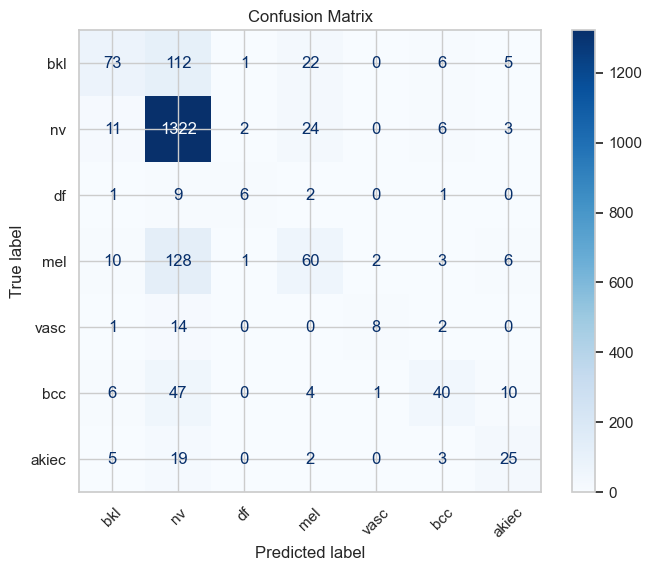

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

class_names = list(dataset.label_mapping.keys())

fig, ax = plt.subplots(figsize=(8, 6))  # ✅ Create fig
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues", ax=ax)
plt.title("Confusion Matrix")

# ✅ Upload to  wandb
wandb.log({"Confusion Matrix": wandb.Image(fig)})

plt.show()



In [20]:
from sklearn.metrics import classification_report

# 模型评估
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get report dictionary (for convenient logging with wandb)
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=True)

# Print to consolePrint to console
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Upload F1 score for each class to wandb
f1_logs = {f"f1_score/{label}": report[label]["f1-score"] for label in class_names}

# Also log macro and weighted averages
f1_logs["f1_score/macro_avg"] = report["macro avg"]["f1-score"]
f1_logs["f1_score/weighted_avg"] = report["weighted avg"]["f1-score"]

# log in wandb
wandb.log(f1_logs)

wandb.finish()

              precision    recall  f1-score   support

         bkl     0.6822    0.3333    0.4479       219
          nv     0.8007    0.9664    0.8758      1368
          df     0.6000    0.3158    0.4138        19
         mel     0.5263    0.2857    0.3704       210
        vasc     0.7273    0.3200    0.4444        25
         bcc     0.6557    0.3704    0.4734       108
       akiec     0.5102    0.4630    0.4854        54

    accuracy                         0.7659      2003
   macro avg     0.6432    0.4364    0.5016      2003
weighted avg     0.7405    0.7659    0.7340      2003



f1_score/akiec,▁
f1_score/bcc,▁
f1_score/bkl,▁
f1_score/df,▁
f1_score/macro_avg,▁
f1_score/mel,▁
f1_score/nv,▁
f1_score/vasc,▁
f1_score/weighted_avg,▁
train/accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████▇██
train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁


In [2]:
pip install owlready2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 63.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.48-cp311-cp311-linux_x86_64.whl size=24551726 sha256=4de424d4971f55150f74b2c9eeb4da8ecbcbdf59b886cb7bed9842fdf997f17f
  Stored in directory: /root/.cache/pip/wheels/2a/4f/b2/88d834aab03077e1611b46825f45c06ac4db07b77ee45eadd5
Successfully built owlready2


In [24]:
from owlready2 import *
import pandas as pd
from owlready2 import World, get_ontology

# Step 1: Load the .owl file locally and skip any external HTTP imports
owl_path = "/content/drive/MyDrive/dermatology.owl"
world    = World()
onto     = world.get_ontology(f"file://{owl_path}")
onto.load(only_local=True)

print(f"Loaded ontology at {onto.base_iri} with {len(list(onto.classes()))} classes")


# Step 2: Class names from CNN model output (should match confusion matrix order)
class_names = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

# Step 3: Map label to ontology class name (string form)
label_to_class_name = {
    'nv':   "DERMO_0000337",
    'bkl':  "DERMO_0000108",
    'df':   "DERMO_0000771",
    'mel':  "DERMO_0000970",
    'vasc': "DERMO_0001950",
    'bcc':  "DERMO_0000395",
    'akiec':"DERMO_0000395"
}

# Step 4: Use search_one to map labels to actual OWL classes
label_to_owl_class = {}
for label, cls_name in label_to_class_name.items():
    owl_class = onto.search_one(iri=f"*{cls_name}")
    label_to_owl_class[label] = owl_class

# Step 5: Display the mapping results
for label, owl_class in label_to_owl_class.items():
    print(f"{label}: {owl_class}")

# Step 6: Check if a label is malignant (by checking class ancestry)
mel_class = label_to_owl_class['mel']
nmsc_class = label_to_owl_class['bcc']

def is_malignant_owl(label):
    cls = label_to_owl_class[label]
    return (mel_class in cls.ancestors()) or (nmsc_class in cls.ancestors())

# Step 7: Retrieve semantic path (ancestral path) of a label
def get_owl_path(label):
    cls = label_to_owl_class[label]
    path = []
    visited = set()

    # Recursive DFS to trace ancestry
    def dfs(current):
        if current in visited:
            return
        visited.add(current)
        parents = list(current.is_a)
        for parent in parents:
            dfs(parent)
        # Append class label if available, otherwise use the class name
        if hasattr(current, 'label') and current.label:
            path.append(current.label[0])
        else:
            path.append(current.name)

    dfs(cls)
    return " → ".join(path)

# Step 8: Explain a single prediction (in English with recommendations)
def explain_prediction_owl(label):
    path_str = get_owl_path(label)
    is_malignant = is_malignant_owl(label)
    mal_flag = "⚠️ Malignant" if is_malignant else "✅ Benign"
    recommendation = "Seek medical attention" if is_malignant else "No immediate concern"
    return {
        "Label": label,
        "Ontology Path": path_str,
        "Malignancy": mal_flag,
        "Recommendation": recommendation
    }

# Step 9: Analyze a batch of prediction results (y_pred is a list of index values)
def analyze_predictions(y_pred_indices, class_names, max_display=10):
    results = []
    for i, idx in enumerate(y_pred_indices[:max_display]):
        label = class_names[idx]
        info = explain_prediction_owl(label)
        info["Sample Index"] = i
        results.append(info)
    return pd.DataFrame(results)



Loaded ontology at http://purl.obolibrary.org/obo/DERMO.owl# with 3521 classes
nv: obo.DERMO_0000337
bkl: obo.DERMO_0000108
df: obo.DERMO_0000771
mel: obo.DERMO_0000970
vasc: obo.DERMO_0001950
bcc: obo.DERMO_0000395
akiec: obo.DERMO_0000395


In [19]:
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)        # Tensor of shape (batch_size,)
        y_pred.extend(preds.cpu().tolist())  # add to Python list

print(f"Collected {len(y_pred)} predictions.")


Collected 2003 predictions.


In [20]:

pd.set_option('display.max_colwidth', None)
df = analyze_predictions(y_pred, class_names)
display(df)


,Label,Ontology Path,Malignancy,Recommendation,Sample Index
0,vasc,Thing → disease → cutaneous disease → vascular disorder → vascular birthmark,✅ Benign,No immediate concern,0
1,bkl,Thing → disease → cutaneous disease → pigmentary disorder,✅ Benign,No immediate concern,1
2,bcc,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → non-melanoma skin cancer,⚠️ Malignant,Seek medical attention,2
3,bkl,Thing → disease → cutaneous disease → pigmentary disorder,✅ Benign,No immediate concern,3
4,akiec,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → non-melanoma skin cancer,⚠️ Malignant,Seek medical attention,4
5,mel,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → melanoma,⚠️ Malignant,Seek medical attention,5
6,vasc,Thing → disease → cutaneous disease → vascular disorder → vascular birthmark,✅ Benign,No immediate concern,6
7,df,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → benign epidermal tumor or proliferation,✅ Benign,No immediate concern,7
8,df,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → benign epidermal tumor or proliferation,✅ Benign,No immediate concern,8
9,bkl,Thing → disease → cutaneous disease → pigmentary disorder,✅ Benign,No immediate concern,9


In [26]:
from owlready2 import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load ontology
owl_path = "dermatology.owl"
world = World()
onto = world.get_ontology(f"file://{owl_path}")
onto.load(only_local=True)
print(f"Loaded ontology at {onto.base_iri} with {len(list(onto.classes()))} classes")

# Step 2: Class names
class_names = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

# Step 3: Map label → OWL class
label_to_class_name = {
    'nv':   "DERMO_0000337",
    'bkl':  "DERMO_0000108",
    'df':   "DERMO_0000771",
    'mel':  "DERMO_0000970",
    'vasc': "DERMO_0001950",
    'bcc':  "DERMO_0000395",
    'akiec':"DERMO_0000395"
}
label_to_owl_class = {
    label: onto.search_one(iri=f"*{cls_name}")
    for label, cls_name in label_to_class_name.items()
}
for label, owl_class in label_to_owl_class.items():
    print(f"{label}: {owl_class}")

# Step 4: Malignancy judgment
mel_class = label_to_owl_class['mel']
nmsc_class = label_to_owl_class['bcc']
def is_malignant_owl(label):
    cls = label_to_owl_class[label]
    return (mel_class in cls.ancestors()) or (nmsc_class in cls.ancestors())

# Step 5: Ontology path
def get_owl_path(label):
    cls = label_to_owl_class[label]
    path = []
    visited = set()
    def dfs(current):
        if current in visited or isinstance(current, Restriction):
            return
        visited.add(current)
        for parent in current.is_a:
            dfs(parent)
    # 只处理 ThingClass（真正的类）
        if isinstance(current, ThingClass):
            path.append(current.label[0] if hasattr(current, 'label') and current.label else current.name)
    dfs(cls)
    return " → ".join(path)

# Step 6: Explain single prediction
def explain_prediction_owl(label):
    return {
        "Label": label,
        "Ontology Path": get_owl_path(label),
        "Malignancy": "⚠️ Malignant" if is_malignant_owl(label) else "✅ Benign",
        "Recommendation": "Seek medical attention" if is_malignant_owl(label) else "No immediate concern"
    }

# Step 7: Metadata validation logic
def validate_prediction_ontology(label, metadata_row):
    cls = label_to_owl_class.get(label)
    if cls is None: return "❓ Unknown class"
    messages = []

    if hasattr(cls, "affectsAgeGroup"):
        expected = [a.name.lower() for a in cls.affectsAgeGroup]
        age = metadata_row.get("age")
        if age is not None:
            if age < 20 and "young" not in expected:
                messages.append("❌ Not for young")
            elif 20 <= age <= 60 and "adult" not in expected:
                messages.append("❌ Not for adult")
            elif age > 60 and "elderly" not in expected:
                messages.append("❌ Not for elderly")

    if hasattr(cls, "moreFrequentIn"):
        expected_gender = [g.name.lower() for g in cls.moreFrequentIn]
        actual_gender = str(metadata_row.get("sex", "")).lower()
        if actual_gender not in expected_gender:
            messages.append(f"❌ Gender: {actual_gender}")

    if hasattr(cls, "hasTypicalLocation"):
        expected_locations = [loc.name.lower() for loc in cls.hasTypicalLocation]
        actual_location = str(metadata_row.get("localization", "")).lower()
        if actual_location not in expected_locations:
            messages.append(f"❌ Location: {actual_location}")

    return "✅ OK" if not messages else " / ".join(messages)

# Step 8: Unified analyzer
def analyze_predictions(y_pred_indices, class_names, metadata=None, max_display=10):
    results = []
    for i, idx in enumerate(y_pred_indices[:max_display]):
        label = class_names[idx]
        info = explain_prediction_owl(label)
        info["Sample Index"] = i
        if metadata:
            meta = metadata[i]
            info["Validation"] = validate_prediction_ontology(label, meta)
            info["Age"] = meta.get("age")
            info["Sex"] = meta.get("sex")
            info["Location"] = meta.get("localization")
        results.append(info)
    return pd.DataFrame(results)

# Step 9: Load metadata CSV
csv_path = r"D:\download\archive DS50\HAM10000_metadata.csv"
df_meta = pd.read_csv(csv_path)
metadata_list = df_meta[['age', 'sex', 'localization']].to_dict(orient='records')

# Step 10: Run on prediction results (replace y_pred)
# Example: y_pred = [1, 4, 0, 3, 5, 6, 2, 0, 3, 1]
results_df = analyze_predictions(y_pred, class_names, metadata=metadata_list, max_display=20)
display(results_df)

# Step 11: Optional export
results_df.to_csv("prediction_with_validation.csv", index=False)



* Owlready2 * WARNING: DataProperty http://purl.obolibrary.org/obo/DERMO.owl#affectsAgeGroup belongs to more than one entity types: [owl.ObjectProperty, owl.DatatypeProperty, owl.topObjectProperty, owl.topDataProperty]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://purl.obolibrary.org/obo/DERMO.owl#hasTypicalLocation belongs to more than one entity types: [owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://purl.obolibrary.org/obo/DERMO.owl#moreFrequentIn belongs to more than one entity types: [owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...


Loaded ontology at http://purl.obolibrary.org/obo/DERMO.owl# with 3544 classes
nv: obo.DERMO_0000337
bkl: obo.DERMO_0000108
df: obo.DERMO_0000771
mel: obo.DERMO_0000970
vasc: obo.DERMO_0001950
bcc: obo.DERMO_0000395
akiec: obo.DERMO_0000395


,Label,Ontology Path,Malignancy,Recommendation,Sample Index,Validation,Age,Sex,Location
0,nv,Thing → disease → cutaneous disease → pigmenta...,✅ Benign,No immediate concern,0,✅ OK,80.0,male,scalp
1,nv,Thing → disease → cutaneous disease → pigmenta...,✅ Benign,No immediate concern,1,✅ OK,80.0,male,scalp
2,bcc,Thing → disease → cutaneous disease → disorder...,⚠️ Malignant,Seek medical attention,2,❌ Location: scalp,80.0,male,scalp
3,vasc,Thing → disease → cutaneous disease → vascular...,✅ Benign,No immediate concern,3,❌ Not for elderly / ❌ Location: scalp,80.0,male,scalp
4,mel,Thing → disease → cutaneous disease → disorder...,⚠️ Malignant,Seek medical attention,4,✅ OK,75.0,male,ear
5,nv,Thing → disease → cutaneous disease → pigmenta...,✅ Benign,No immediate concern,5,✅ OK,75.0,male,ear
6,nv,Thing → disease → cutaneous disease → pigmenta...,✅ Benign,No immediate concern,6,✅ OK,60.0,male,face
7,mel,Thing → disease → cutaneous disease → disorder...,⚠️ Malignant,Seek medical attention,7,✅ OK,60.0,male,face
8,nv,Thing → disease → cutaneous disease → pigmenta...,✅ Benign,No immediate concern,8,✅ OK,70.0,female,back
9,nv,Thing → disease → cutaneous disease → pigmenta...,✅ Benign,No immediate concern,9,✅ OK,70.0,female,back


In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_and_explain_interactive(model, device):
    # Step 1: Input image path
    image_path = "test.jpg"

    # Step 2: Manually enter metadata
    try:
        age = int(input("Enter age: "))
    except:
        age = None
    sex = input("Enter sex (male/female): ").strip().lower()
    localization = input("Enter body location (e.g., back / face / lower extremity): ").strip().lower()

    metadata_row = {
        "age": age,
        "sex": sex,
        "localization": localization
    }

    # Step 3: Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Step 4: Model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        pred_index = predicted.item()

    label = class_names[pred_index]
    info = explain_prediction_owl(label)

    # Step 5: Ontology-based validation
    validation_result = validate_prediction_ontology(label, metadata_row)

    # Step 6: Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {label}\n{info['Malignancy']} | {info['Recommendation']}", fontsize=12)
    plt.show()

    # Step 7: Print detailed information
    print("🔎 Ontology Path:")
    print(info['Ontology Path'])
    print("✅ Metadata Validation:")
    print(validation_result)

    return {
        "Label": label,
        "Ontology Path": info['Ontology Path'],
        "Malignancy": info['Malignancy'],
        "Recommendation": info['Recommendation'],
        "Validation": validation_result
    }


Enter age:  23
Enter sex (male/female):  male
Enter body location (e.g., back / face / lower extremity):  genital


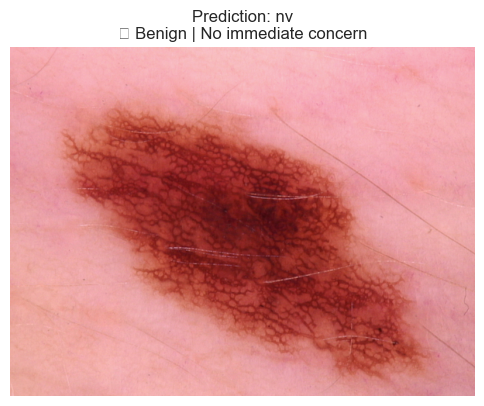

🔎 Ontology Path:
Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions
✅ Metadata Validation:
❌ Location: genital


In [34]:
result = predict_and_explain_interactive(model, device)

In [28]:
pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1

[notice] To update, run: python.exe -m pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: ipython>=6.1.0 in c:\users\123\appdata\local\programs\python\python313\lib\site-packages (from ipywidgets) (8.32.0)

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 39.3 MB/s eta 0:00:00


In [ ]:
#changes to be made for code

#This is for the homework intro to git 

